In [1]:
import torch

In [2]:
def make_data(n_pos, n_neg, max_samples=10000, seed=11):
    assert n_pos <= max_samples
    assert n_neg <= max_samples
    
    torch.manual_seed(seed)

    # https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/11
    X = torch.fmod(torch.randn(max_samples, 2),2) + torch.tensor([-3., 3.])
    
    pos_idx = torch.randperm(max_samples)[:n_pos]
    neg_idx = torch.randperm(max_samples)[:n_neg]
    
    X_pos = X[pos_idx]
    X_neg = X[neg_idx] # reflect over the line `y = x`
    X_neg = X_neg[:, [1, 0]]
    
    
    y_pos = torch.ones(n_pos, dtype=torch.long)
    y_neg = torch.zeros(n_neg, dtype=torch.long)
    
    return X_pos, y_pos, X_neg, y_neg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
def get_fixed_lr(X):
    """Use the largest singular value as fixed SGD LR"""
    _, s, v = torch.svd(X)
    return 1 / s[0]

def compute_importance_weights(labels, target_weights="balanced"):
    from sklearn.utils.class_weight import compute_class_weight
    """Light wrapper around sklearn's compute_class_weight
    Inputs:
        `labels`: torch.Tensor of data labels, e.g. [0, 1, 1, 0, 0, 1] for binary classification
        `target_weights`: either "balanced" representing uniform target distribution or a dictionary that maps classes to weights
    
    Outputs:
        `class_weights`: A torch.Tensor of unnormalized weights for each class e.g. [1, 1] when labels are already balanced.
    
    Oputut can be passed into torch.nn.CrossEntropyLoss as the `weight` kwarg.
    """

    device = labels.device
    classes = torch.unique(labels)
    class_weights = compute_class_weight(
        target_weights,
        classes=classes.detach().cpu().numpy(),
        y=labels.detach().cpu().numpy()
    )  # unnormalized weights
    class_weights = torch.tensor(class_weights).to(torch.float).to(device)
    return class_weights

In [31]:
def contourf_scalar_fn(f, x1_lim, x2_lim, ax=None, device="cpu"):
    g1 = torch.linspace(*x1_lim, 300, device=device)  # grid bounds in x dimension
    g2 = torch.linspace(*x2_lim, 300, device=device)  # grid bounds in y dimension
    x1, x2 = torch.meshgrid(g1, g2)
    X = torch.stack([x1, x2], axis=-1).reshape(-1, 2)

    y = f(X)
    y_grid = y.reshape(len(g1), len(g2))

    lim = max(abs(torch.min(y).item()), abs(torch.max(y).item()))

    if ax is None:
        fig, ax = plt.subplots()
    cs = ax.contourf(x1.detach().cpu().numpy(), x2.detach().cpu().numpy(), y_grid.detach().cpu().numpy(), cmap="coolwarm", vmin=-lim, vmax=lim, levels=5)
    #cb = fig.colorbar(cs, ax=ax)
    return ax

100%|██████████| 10000/10000 [10:10<00:00, 16.39it/s]


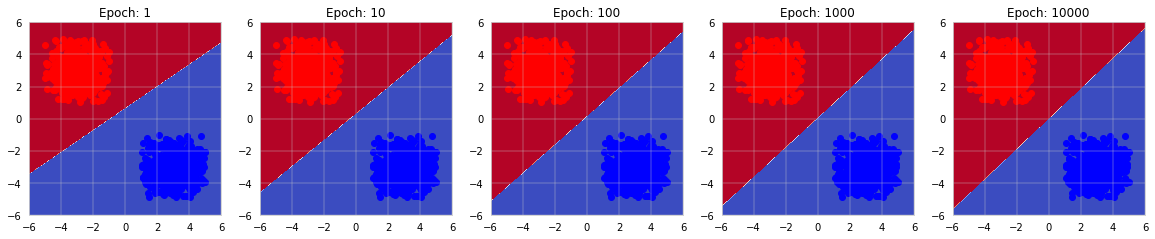

In [34]:
from tqdm import tqdm

shuffle = True
batch_size = 8
device = "cuda"

X_pos, y_pos, X_neg, y_neg = make_data(512, 512)

X_train = torch.cat([X_pos, X_neg])
y_train = torch.cat([y_pos, y_neg])

X_train = X_train.to(device)
y_train = y_train.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

logistic_model = torch.nn.Sequential(torch.nn.Linear(2, 2))
mlp_model = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2))
model = logistic_model.to(device)

n_epochs = 10000
lr = get_fixed_lr(X_train)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
class_weights = compute_importance_weights(y_train)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

checkpoints = [1, 10, 100, 1000, 10000]
fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints)* 4, 4))
chkpts_axes = dict(zip(checkpoints, axes))

for epoch in tqdm(range(n_epochs)):
    epoch += 1  # one-indexing

    for x, y in dataloader:
        optimizer.zero_grad()
        
        logits = model(x)
        loss = loss_fn(logits, y)
        
        loss.backward()
        optimizer.step()

    if epoch in chkpts_axes:
        ax = chkpts_axes[epoch]
        def predict(x):
            with torch.no_grad():
                logits = model(x)
            y_pred = torch.argmax(logits, -1)
            pos_neg_y = y_pred * 2 - 1  # Convert from {0, 1} to {-1, 1} for color map
            return pos_neg_y

        contourf_scalar_fn(predict, (-6, 6), (-6,6), ax, device)

        ax.scatter(*X_pos.T, color='r')
        ax.scatter(*X_neg.T, color='b')
        
        ax.set(aspect="equal", xlim=(-6, 6), ylim=(-6, 6))
        ax.set(title=f"Epoch: {epoch}")

In [35]:
fig.savefig("binary-1-1.pdf")

100%|██████████| 10000/10000 [05:39<00:00, 29.46it/s]


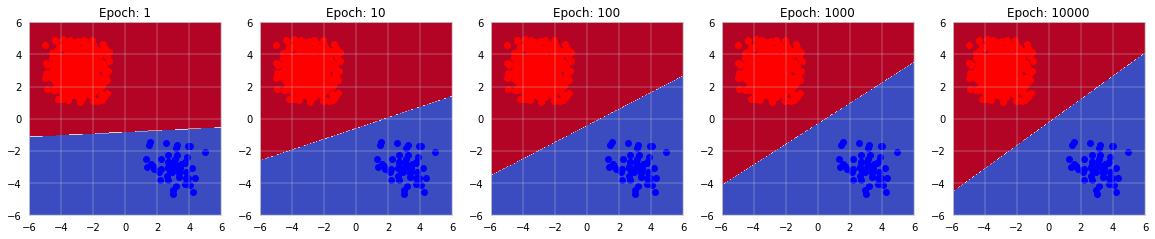

In [37]:
from tqdm import tqdm

shuffle = True
batch_size = 8
device = "cuda"

X_pos, y_pos, X_neg, y_neg = make_data(512, 51)

X_train = torch.cat([X_pos, X_neg])
y_train = torch.cat([y_pos, y_neg])

X_train = X_train.to(device)
y_train = y_train.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

logistic_model = torch.nn.Sequential(torch.nn.Linear(2, 2))
mlp_model = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2))
model = logistic_model.to(device)

n_epochs = 10000
lr = get_fixed_lr(X_train)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
class_weights = compute_importance_weights(y_train)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

checkpoints = [1, 10, 100, 1000, 10000]
fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints)* 4, 4))
chkpts_axes = dict(zip(checkpoints, axes))

for epoch in tqdm(range(n_epochs)):
    epoch += 1  # one-indexing

    for x, y in dataloader:
        optimizer.zero_grad()
        
        logits = model(x)
        loss = loss_fn(logits, y)
        
        loss.backward()
        optimizer.step()

    if epoch in chkpts_axes:
        ax = chkpts_axes[epoch]
        def predict(x):
            with torch.no_grad():
                logits = model(x)
            y_pred = torch.argmax(logits, -1)
            pos_neg_y = y_pred * 2 - 1  # Convert from {0, 1} to {-1, 1} for color map
            return pos_neg_y

        contourf_scalar_fn(predict, (-6, 6), (-6,6), ax, device)

        ax.scatter(*X_pos.T, color='r')
        ax.scatter(*X_neg.T, color='b')
        
        ax.set(aspect="equal", xlim=(-6, 6), ylim=(-6, 6))
        ax.set(title=f"Epoch: {epoch}")

In [38]:
fig.savefig("binary-10-1.pdf")

100%|██████████| 10000/10000 [05:38<00:00, 29.50it/s]


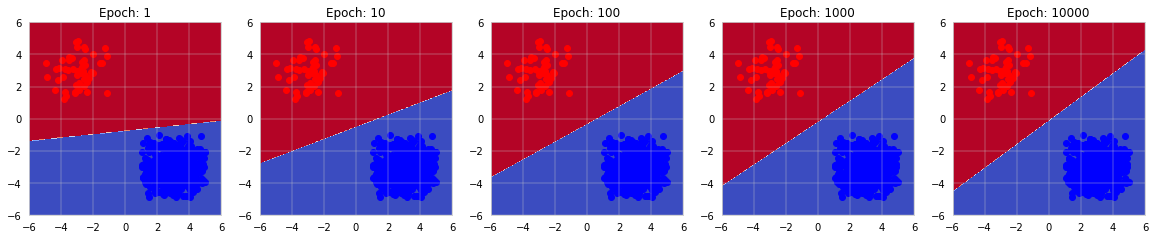

In [39]:
from tqdm import tqdm

shuffle = True
batch_size = 8
device = "cuda"

X_pos, y_pos, X_neg, y_neg = make_data(51, 512)

X_train = torch.cat([X_pos, X_neg])
y_train = torch.cat([y_pos, y_neg])

X_train = X_train.to(device)
y_train = y_train.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

logistic_model = torch.nn.Sequential(torch.nn.Linear(2, 2))
mlp_model = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2))
model = logistic_model.to(device)

n_epochs = 10000
lr = get_fixed_lr(X_train)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
class_weights = compute_importance_weights(y_train)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

checkpoints = [1, 10, 100, 1000, 10000]
fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints)* 4, 4))
chkpts_axes = dict(zip(checkpoints, axes))

for epoch in tqdm(range(n_epochs)):
    epoch += 1  # one-indexing

    for x, y in dataloader:
        optimizer.zero_grad()
        
        logits = model(x)
        loss = loss_fn(logits, y)
        
        loss.backward()
        optimizer.step()

    if epoch in chkpts_axes:
        ax = chkpts_axes[epoch]
        def predict(x):
            with torch.no_grad():
                logits = model(x)
            y_pred = torch.argmax(logits, -1)
            pos_neg_y = y_pred * 2 - 1  # Convert from {0, 1} to {-1, 1} for color map
            return pos_neg_y

        contourf_scalar_fn(predict, (-6, 6), (-6,6), ax, device)

        ax.scatter(*X_pos.T, color='r')
        ax.scatter(*X_neg.T, color='b')
        
        ax.set(aspect="equal", xlim=(-6, 6), ylim=(-6, 6))
        ax.set(title=f"Epoch: {epoch}")

In [40]:
fig.savefig("binary-1-10.pdf")

100%|██████████| 10000/10000 [05:39<00:00, 29.42it/s]


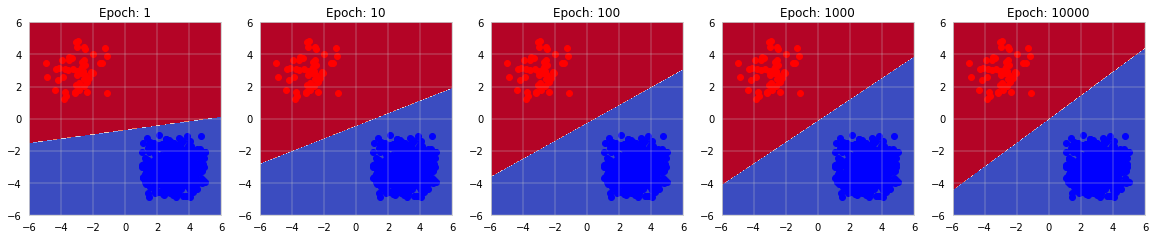

In [41]:
from tqdm import tqdm

shuffle = True
batch_size = 8
device = "cuda"

X_pos, y_pos, X_neg, y_neg = make_data(51, 512)

X_train = torch.cat([X_pos, X_neg])
y_train = torch.cat([y_pos, y_neg])

X_train = X_train.to(device)
y_train = y_train.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

logistic_model = torch.nn.Sequential(torch.nn.Linear(2, 2))
mlp_model = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2))
model = logistic_model.to(device)

n_epochs = 10000
lr = get_fixed_lr(X_train)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#class_weights = compute_importance_weights(y_train)
loss_fn = torch.nn.CrossEntropyLoss(weight=None)

checkpoints = [1, 10, 100, 1000, 10000]
fig, axes = plt.subplots(1, len(checkpoints), figsize=(len(checkpoints)* 4, 4))
chkpts_axes = dict(zip(checkpoints, axes))

for epoch in tqdm(range(n_epochs)):
    epoch += 1  # one-indexing

    for x, y in dataloader:
        optimizer.zero_grad()
        
        logits = model(x)
        loss = loss_fn(logits, y)
        
        loss.backward()
        optimizer.step()

    if epoch in chkpts_axes:
        ax = chkpts_axes[epoch]
        def predict(x):
            with torch.no_grad():
                logits = model(x)
            y_pred = torch.argmax(logits, -1)
            pos_neg_y = y_pred * 2 - 1  # Convert from {0, 1} to {-1, 1} for color map
            return pos_neg_y

        contourf_scalar_fn(predict, (-6, 6), (-6,6), ax, device)

        ax.scatter(*X_pos.T, color='r')
        ax.scatter(*X_neg.T, color='b')
        
        ax.set(aspect="equal", xlim=(-6, 6), ylim=(-6, 6))
        ax.set(title=f"Epoch: {epoch}")

In [42]:
fig.savefig("binary-1-10-no-is.pdf")